## Sound devices

In [2]:
import sounddevice as sd
sd.query_devices()

   0 HDA Intel PCH: CX20632 Analog (hw:0,0), ALSA (2 in, 0 out)
   1 HDA Intel PCH: CX20632 Alt Analog (hw:0,2), ALSA (2 in, 0 out)
   2 HDA Intel PCH: HDMI 0 (hw:0,3), ALSA (0 in, 8 out)
   3 HDA Intel PCH: HDMI 1 (hw:0,7), ALSA (0 in, 8 out)
   4 HDA Intel PCH: HDMI 2 (hw:0,8), ALSA (0 in, 8 out)
   5 HDA Intel PCH: HDMI 3 (hw:0,9), ALSA (0 in, 8 out)
   6 HDA Intel PCH: HDMI 4 (hw:0,10), ALSA (0 in, 8 out)
   7 HD Pro Webcam C920: USB Audio (hw:1,0), ALSA (2 in, 0 out)
   8 sysdefault, ALSA (128 in, 0 out)
   9 hdmi, ALSA (0 in, 8 out)
  10 samplerate, ALSA (128 in, 0 out)
  11 speexrate, ALSA (128 in, 0 out)
  12 pulse, ALSA (32 in, 32 out)
  13 upmix, ALSA (8 in, 0 out)
  14 vdownmix, ALSA (6 in, 0 out)
* 15 default, ALSA (32 in, 32 out)

## Postprocessing

In [7]:
import os, h5py
import numpy as np
from modules.postprocessing import pack

In [3]:
source = '/home/sobolev/nevermind/Andrey/data'
#source = 'Z:\\Andrey\\data'
animal = '008229'
session = '008229_hippoSIT_2022-06-09_14-15-49'

session_path = os.path.join(source, animal, session)
h5name = pack(session_path)

In [8]:
with h5py.File(h5name, 'r') as f:
    islands = np.array(f['raw']['islands'])

## Reading .spk

In [150]:
def get_wf_metrics(wf):
    idx_tr = np.argmin(wf)  # idx of trough
    if idx_tr > 0:
        peak_l_idx = np.argmax(wf[:idx_tr])
        peak_r_idx = np.argmax(wf[idx_tr:]) + idx_tr
        amp = wf[peak_l_idx] - wf.min()  # spike amplitude
        width = idx_tr - peak_l_idx  # spike width
        return amp, width
    else:
        return 0, 0

In [266]:
def get_unit_idxs(units):
    idxs = np.zeros(0, dtype=np.int16)
    for unit in units:
        idxs = np.concatenate([idxs, np.where(cluster_map == unit)[0]])
    return idxs

In [464]:
import os
import numpy as np

source  = '/home/sobolev/nevermind/Andrey/data'
session = '009266_hippoSIT_2023-06-21_08-15-10'
animal      = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
spk_file = os.path.join(sessionpath, session + '.spk.3')
clu_file = os.path.join(sessionpath, session + '.clu.3')

In [465]:
block = np.fromfile(spk_file, dtype=np.int16)
cluster_map = np.loadtxt(clu_file, dtype=np.uint16)

channels_no = 8
samples_no  = 50
spikes_no   = int(block.shape[0]/(channels_no*samples_no))

b1 = block.reshape([spikes_no, samples_no, channels_no])
b1.shape

(116716, 50, 8)

In [466]:
idxs = get_unit_idxs([14, 16])  # selected units

b2 = b1[idxs]
b2.shape

(5425, 50, 8)

In [467]:
# save the waveforms as .npy
np.save('waveforms.npy', b2)

## Mean spike waveforms

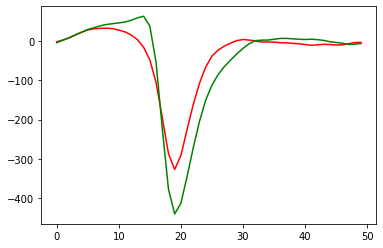

In [413]:
for ch in [7]:
    plt.plot(b1[:, :, ch][get_unit_idxs([14])].mean(axis=0), color='red')
    plt.plot(b1[:, :, ch][get_unit_idxs([16])].mean(axis=0), color='green')

In [418]:
idxs = get_unit_idxs([14, 16])

spk_metrics = np.zeros((len(idxs), 2))
for i, wf in enumerate(b1[:, :, 6][idxs]): # taking channel 7
    spk_metrics[i] = np.array(get_wf_metrics(wf))

(0.0, 30.0)

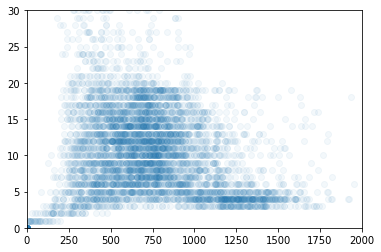

In [419]:
plt.scatter(spk_metrics[:, 0], spk_metrics[:, 1], alpha=0.05)
plt.xlim(0, 2000)
plt.ylim(0, 30)

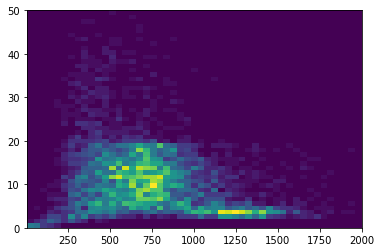

In [280]:
_ = plt.hist2d(spk_metrics[:, 0], spk_metrics[:, 1], bins=[np.linspace(5, 2000, 50), np.linspace(0, 50, 50)])

In [375]:
from sklearn.mixture import GaussianMixture

y_pred = GaussianMixture(n_components=3, init_params='kmeans').fit_predict(spk_metrics)

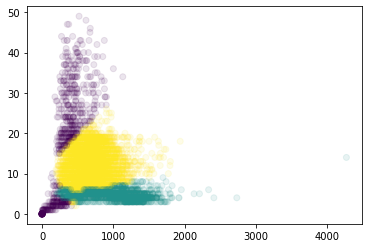

In [376]:
plt.scatter(spk_metrics[:, 0], spk_metrics[:, 1], c=y_pred, alpha=0.1)

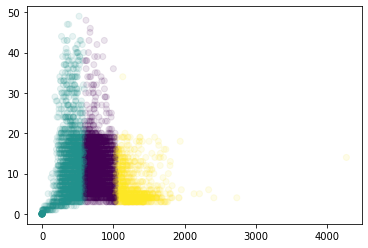

In [424]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3).fit_predict(spk_metrics)
plt.scatter(spk_metrics[:, 0], spk_metrics[:, 1], c=kmeans, alpha=0.1)

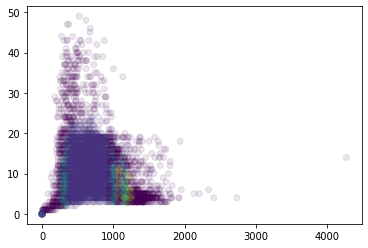

In [425]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=6, min_samples=25).fit(spk_metrics)
plt.scatter(spk_metrics[:, 0], spk_metrics[:, 1], c=clustering.labels_, alpha=0.1)
#plt.xlim(0, 1500)

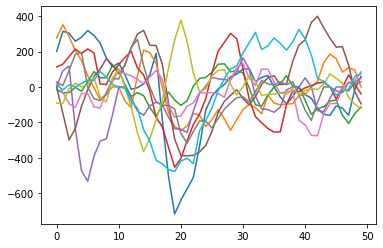

In [235]:
import matplotlib.pyplot as plt


for spk in b1[:, :, 5][idxs[:10]]:
    _ = plt.plot(spk)

In [421]:
from sklearn import decomposition

selection = b1[:, :, 6][idxs]

pca = decomposition.PCA(n_components=3)
pca.fit(selection)
X = pca.transform(selection)

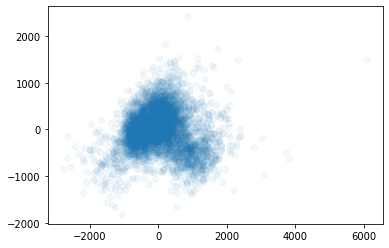

In [423]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.05)

In [448]:
y_pred

array([1, 0, 1, ..., 0, 0, 0])

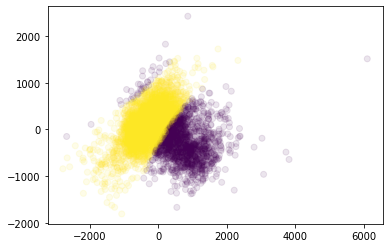

In [447]:
y_pred = GaussianMixture(n_components=2, init_params='kmeans').fit_predict(X[:, :2])
plt.scatter(X[:, 0], X[:, 1], c=y_pred, alpha=0.1)

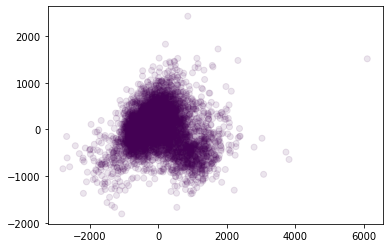

In [441]:
# try DBSCAN !

In [452]:
b1.shape

(116716, 50, 8)

In [453]:
# building feature vectors for all channels
spk_fet = np.zeros((len(idxs), 2*b1.shape[2]))

for i, idx in enumerate(idxs):  # iterate over spikes
    for ch in range(8):  # iterate over channels
        wf = b1[idx, :, ch]
        amp, width = get_wf_metrics(wf)
        spk_fet[i, ch*2] = amp
        spk_fet[i, ch*2 + 1] = width

In [455]:
pca = decomposition.PCA(n_components=3)
pca.fit(spk_fet)
Z = pca.transform(spk_fet)

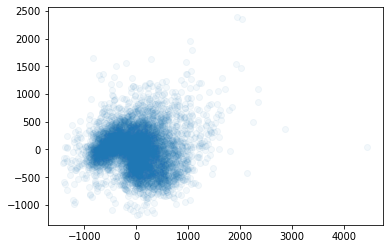

In [459]:
plt.scatter(Z[:, 0], Z[:, 1], alpha=0.05)

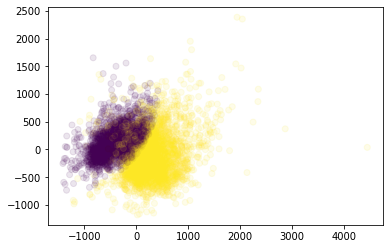

In [463]:
y_pred = GaussianMixture(n_components=2, init_params='kmeans').fit_predict(Z)
plt.scatter(Z[:, 0], Z[:, 1], c=y_pred, alpha=0.1)

## Applying PCA on spike waveforms

In [449]:
# flattening waveforms across channels
b2 = np.zeros((b1.shape[0], b1.shape[1]*b1.shape[2])) 
for i, spk2D in enumerate(b1):
    b2[i] = spk2D.T.flatten()

In [450]:
b2.shape

(116716, 400)

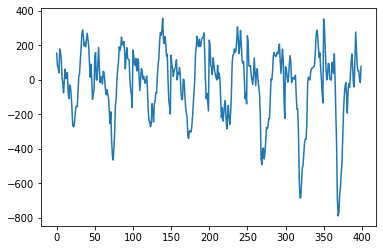

In [63]:
plt.plot(b2[1000])

In [64]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=3)
pca.fit(b2)
X = pca.transform(b2)

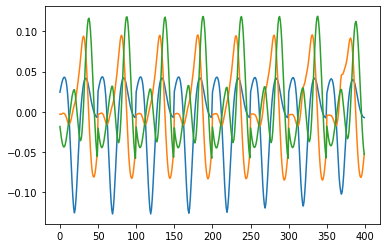

In [66]:
fig, ax = plt.subplots(1, 1)
ax.plot(pca.components_[0])
ax.plot(pca.components_[1])
ax.plot(pca.components_[2])

(array([[ 0.,  1.,  0., ...,  3.,  1.,  4.],
        [ 0.,  1.,  0., ...,  0.,  1.,  2.],
        [ 0.,  0.,  0., ...,  0.,  4.,  0.],
        ...,
        [ 3., 10.,  5., ...,  6.,  7.,  6.],
        [ 5.,  6., 10., ...,  7.,  3.,  6.],
        [ 4.,  7.,  4., ...,  3.,  2.,  7.]]),
 array([-7500.        , -7244.89795918, -6989.79591837, -6734.69387755,
        -6479.59183673, -6224.48979592, -5969.3877551 , -5714.28571429,
        -5459.18367347, -5204.08163265, -4948.97959184, -4693.87755102,
        -4438.7755102 , -4183.67346939, -3928.57142857, -3673.46938776,
        -3418.36734694, -3163.26530612, -2908.16326531, -2653.06122449,
        -2397.95918367, -2142.85714286, -1887.75510204, -1632.65306122,
        -1377.55102041, -1122.44897959,  -867.34693878,  -612.24489796,
         -357.14285714,  -102.04081633,   153.06122449,   408.16326531,
          663.26530612,   918.36734694,  1173.46938776,  1428.57142857,
         1683.67346939,  1938.7755102 ,  2193.87755102,  2448.97959

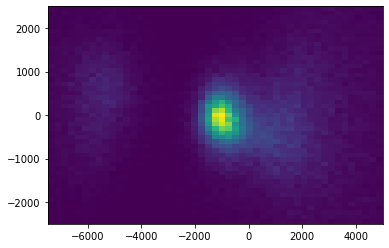

In [79]:
plt.hist2d(X[:, 0], X[:, 2], bins=[np.linspace(-7500, 5000, 50), np.linspace(-2500, 2500, 50)])

In [1]:
import pandas
human_data = pandas.read_csv('https://content.labxchange.org/labs/datasets/CodeSciLab/HumanHeightWeightData.csv')